In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [333]:
#download pretrained pipeline package

spacy.cli.download("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#### Problem Statement
Build a machine learning model to classify Reddit posts from r/technology and r/gadgets into emerging technology categories (e.g., AI, 5G, blockchain, electric vehicles) based on post titles. The goal is to automatically label posts with the technology they are discussing and analyze the distribution of posts across these categories to identify trends.
#### Evaluation Criteria
Success will be measured by the model’s classification accuracy, aiming for at least 85% accuracy in identifying the correct technology trend. The model will be evaluated using precision, recall, and F1 score. Additionally, we’ll track the number of posts per category to determine which technology trends are most discussed.
#### Stake Holders
The project is relevant for companies, investors, and tech enthusiasts who want to understand which emerging technologies are being talked about the most and are likely to gain traction. It helps in making data-driven decisions about innovation trends and tech investments.


### Load Dataset

In [336]:
data = pd.read_csv('./data/reddit_posts.csv')
data.head()

,post_id,title,content,created_utc,subreddit
0,1fufbfm,I'm a Tech CEO at the Berlin Global Dialogue (...,**Edit 3**: I think all done for now but I wan...,1.727873e+09,technology
1,1fycsm9,Nintendo Switch Modder Who Refused to Shut Dow...,NaN,1.728321e+09,technology
2,1fy77rz,Fisker’s HQ abandoned in “complete disarray” w...,NaN,1.728307e+09,technology
3,1fycpyq,Google Will Track Your Location ‘Every 15 Minu...,NaN,1.728321e+09,technology
4,1fy708i,Hacker attack disrupts Russian state media on ...,NaN,1.728306e+09,technology


### Data Cleaning

In [338]:
data.shape

(5181, 5)

In [339]:
data.isna().sum()

post_id           0
title             0
content        5157
created_utc       0
subreddit         0
dtype: int64

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5181 entries, 0 to 5180
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      5181 non-null   object 
 1   title        5181 non-null   object 
 2   content      24 non-null     object 
 3   created_utc  5181 non-null   float64
 4   subreddit    5181 non-null   object 
dtypes: float64(1), object(4)
memory usage: 202.5+ KB


Content is missing in most of the observations, we can drop this as it does not provide any significant importance to dataset.

In [342]:
#change the created utc to readable date format
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
data.head()

,post_id,title,content,created_utc,subreddit
0,1fufbfm,I'm a Tech CEO at the Berlin Global Dialogue (...,**Edit 3**: I think all done for now but I wan...,2024-10-02 12:46:00,technology
1,1fycsm9,Nintendo Switch Modder Who Refused to Shut Dow...,NaN,2024-10-07 17:06:01,technology
2,1fy77rz,Fisker’s HQ abandoned in “complete disarray” w...,NaN,2024-10-07 13:09:23,technology
3,1fycpyq,Google Will Track Your Location ‘Every 15 Minu...,NaN,2024-10-07 17:02:56,technology
4,1fy708i,Hacker attack disrupts Russian state media on ...,NaN,2024-10-07 12:59:38,technology


In [343]:
data['subreddit'].value_counts()

subreddit
technology    3062
gadgets       2119
Name: count, dtype: int64

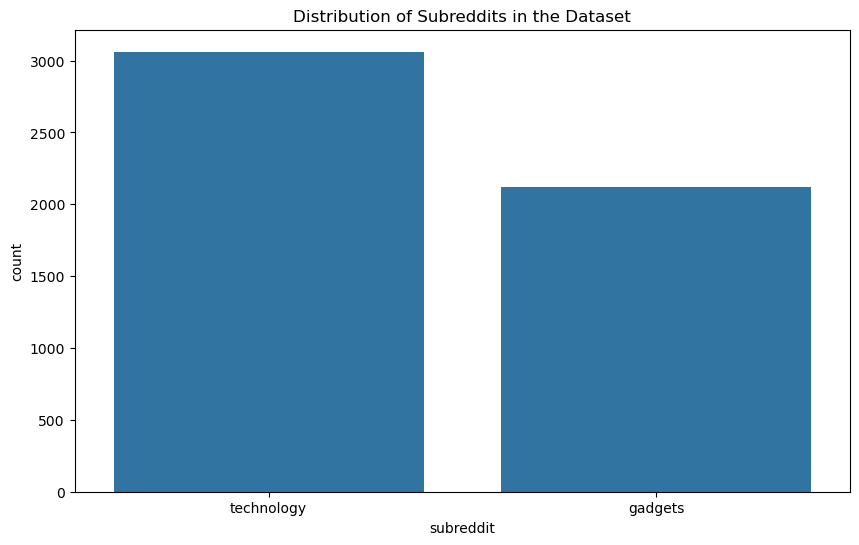

In [400]:

# Plot distribution of the subreddit column
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='subreddit')
plt.title('Distribution of Subreddits in the Dataset');



In [402]:
data['post_id'].nunique()


5181

Text(0, 0.5, 'Average Title Length')

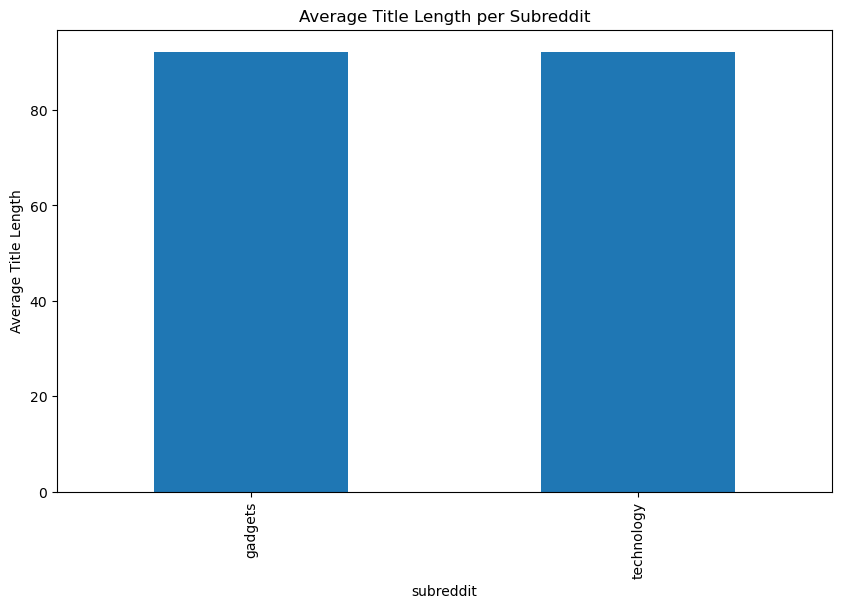

In [412]:
# Average length of titles per subreddit
data['title_length'] = data['title'].apply(len)
avg_title_length_per_subreddit = data.groupby('subreddit')['title_length'].mean()

# Plot average title length per subreddit
plt.figure(figsize=(10,6))
avg_title_length_per_subreddit.plot(kind='bar')
plt.title('Average Title Length per Subreddit')
plt.ylabel('Average Title Length')


### Data Processing


In [347]:

#load medium pipeline
nlp = spacy.load('en_core_web_md')

In [348]:
text = data['title']
def preprocess_text(text):
    '''
    Preprocesses a given text by tokenizing, removing stopwords,punctuations and lemmatizing.
    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: Only alphabetic tokens are included, with punctuation and numbers removed.
    '''
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Only keep alphabetic tokens, remove stopwords, punctuation
        if token.is_alpha and not token.is_stop:
            #lemmatized the tokens and convert to lowercase
            tokens.append(token.lemma_.lower())
    return " ".join(tokens)
#apply the preprocessing to text
data['processed_text'] = data['title'].apply(preprocess_text)


In [349]:
data.head()

,post_id,title,content,created_utc,subreddit,processed_text
0,1fufbfm,I'm a Tech CEO at the Berlin Global Dialogue (...,**Edit 3**: I think all done for now but I wan...,2024-10-02 12:46:00,technology,tech ceo berlin global dialogue w openai emman...
1,1fycsm9,Nintendo Switch Modder Who Refused to Shut Dow...,NaN,2024-10-07 17:06:01,technology,nintendo switch modder refuse shut take court ...
2,1fy77rz,Fisker’s HQ abandoned in “complete disarray” w...,NaN,2024-10-07 13:09:23,technology,fisker hq abandon complete disarray apparent h...
3,1fycpyq,Google Will Track Your Location ‘Every 15 Minu...,NaN,2024-10-07 17:02:56,technology,google track location gps disabled
4,1fy708i,Hacker attack disrupts Russian state media on ...,NaN,2024-10-07 12:59:38,technology,hacker attack disrupt russian state medium put...


### Model Preparation

In [351]:
# Define X and y.
X = data['processed_text']
y = data['subreddit']

### Train Test Split

In [353]:
# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


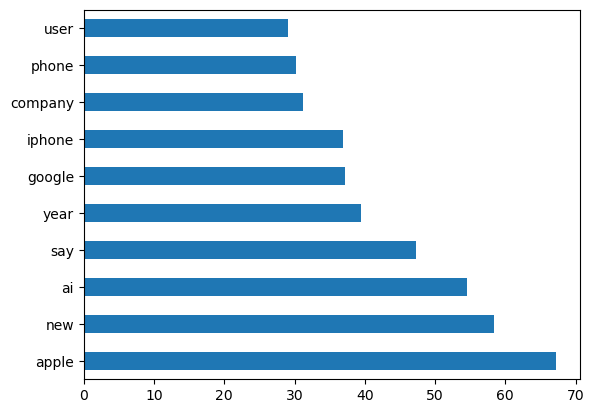

In [417]:

# Instantiate the transformer.
tvec = TfidfVectorizer()
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

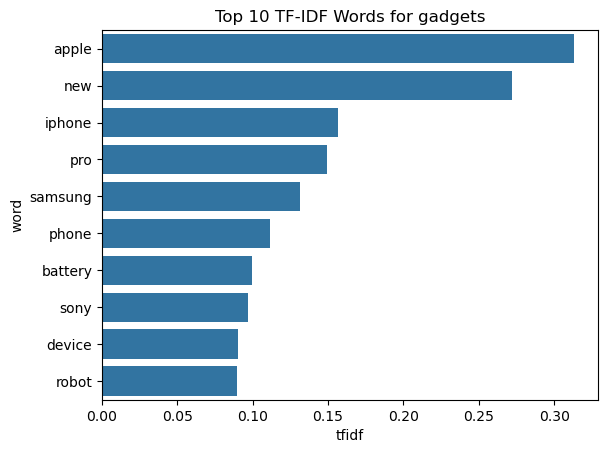

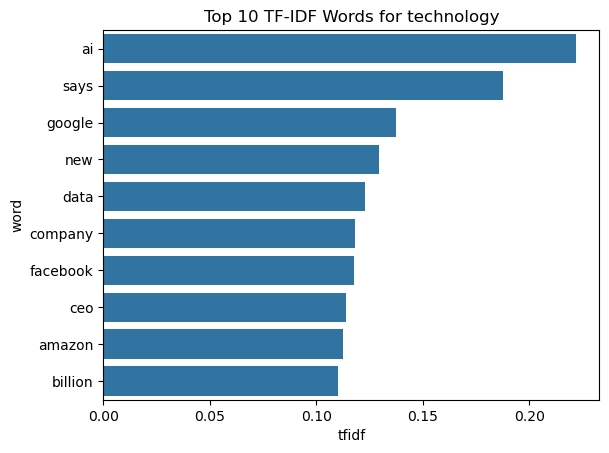

In [421]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['title'])

# Sum TF-IDF scores for each subreddit
subreddit_tfidf = data.groupby('subreddit')['title'].apply(lambda x: ' '.join(x))
for subreddit, titles in subreddit_tfidf.items():
    tfidf_data = tfidf_vectorizer.transform([titles])
    tfidf_scores = tfidf_data.toarray().sum(axis=0)
    tfidf_freq = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), 'tfidf': tfidf_scores})
    tfidf_freq = tfidf_freq.sort_values(by='tfidf', ascending=False).head(10)

    # Plot the top 10 words by TF-IDF score
    sns.barplot(data=tfidf_freq, x='tfidf', y='word')
    plt.title(f'Top 10 TF-IDF Words for {subreddit}')
    plt.show()


### Baseline Accuracy

In [355]:
y.value_counts(normalize = True)

subreddit
technology    0.591006
gadgets       0.408994
Name: proportion, dtype: float64

### Model 1: Count Vectorization with Logistic Regression

In [433]:
logr_pipe = Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('logr',LogisticRegression())
    ]
)

grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85, 1.0],      # Ignore very frequent words
    'cvec__min_df': [1, 2, 5],              # Ignore very infrequent words
    'cvec__max_features': [None, 5000, 10000],  # Limit on the number of features

    'logr__C': [0.01, 0.1, 1.0, 10],        # Regularization strength
    'logr__penalty': ['l2'],                # L2 regularization (Ridge)
    'logr__solver': ['lbfgs', 'liblinear']  # Solvers suitable for small datasets
}


gs_logr = GridSearchCV(logr_pipe,pipe_params,n_jobs=-1)
gs_logr.fit(X_train,y_train)
print(f' Best parameters:{gs_logr.best_params_}')
print(f' Best score:{gs_logr.best_score_}')

 Best parameters:{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'logr__penalty': 'l2'}
 Best score:0.8517374517374516


In [358]:
###Logistic Regression Coefficients 
print(f"Logistic Regression Coefficients: {gs_logr.best_estimator_.named_steps['logr'].coef_}")
print(f"Logistic Regression Intercept: {gs_logr.best_estimator_.named_steps['logr'].intercept_}")


Logistic Regression Coefficients: [[ 0.2638401   0.31717078 -0.09231588 ... -0.10560148  0.44982454
   0.04415129]]
Logistic Regression Intercept: [0.54246857]


### Model Evaluation

In [360]:
preds = gs_logr.predict(X_test)

train_accuracy = round(gs_logr.score(X_train, y_train), 2)
test_accuracy = round(gs_logr.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')

Training Accuracy of Logistic Regression with Count Vectorizer: 0.96
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.87
Training Misclassification Rate: 0.04
Testing Misclassification Rate: 0.13


In [361]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

logr_spec = tn / (tn + fp)
print(f'Logistic Regression specificity: {round(logr_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'Logistic Regression recall: {round(recall,2)}')

Logistic Regression specificity: 0.83
Logistic Regression recall: 0.89


In [362]:
#classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     gadgets       0.84      0.83      0.84       530
  technology       0.88      0.89      0.89       766

    accuracy                           0.87      1296
   macro avg       0.86      0.86      0.86      1296
weighted avg       0.87      0.87      0.87      1296



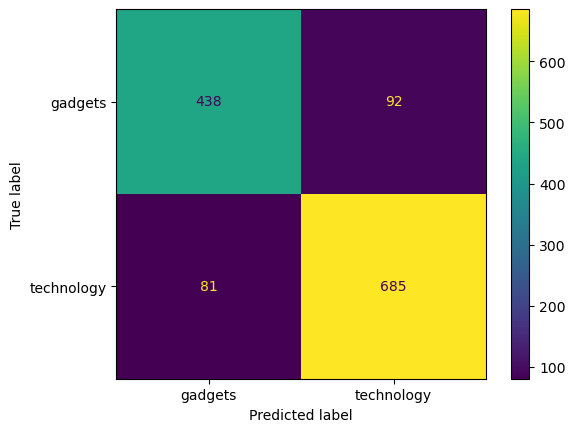

In [363]:
ConfusionMatrixDisplay.from_estimator(gs_logr,X_test,y_test);

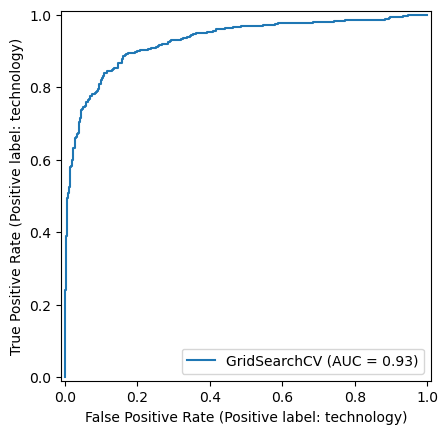

In [364]:
RocCurveDisplay.from_estimator(gs_logr,X_test,y_test);

### Model 2: TF-IDF Vectorization with KNN 

In [366]:
knn_pipe= Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('knn',KNeighborsClassifier())
    ]
)
grid_params={
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'knn__n_neighbors': range(3, 12, 2)
}
gs_knn = GridSearchCV(knn_pipe,grid_params,n_jobs=-1)
gs_knn.fit(X_train,y_train)
print(f' Best parameters:{gs_knn.best_params_}')
print(f' Best score:{gs_knn.best_score_}')

 Best parameters:{'knn__n_neighbors': 11, 'tf-idf__max_df': 0.9, 'tf-idf__max_features': 4000, 'tf-idf__min_df': 2, 'tf-idf__stop_words': None}
 Best score:0.8411840411840412


/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Model Evaluation

In [368]:
pred = gs_knn.predict(X_test)

train_accuracy = round(gs_knn.score(X_train, y_train), 2)
test_accuracy = round(gs_knn.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')

Training Accuracy of Logistic Regression with Count Vectorizer: 0.87
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.85
Training Misclassification Rate: 0.13
Testing Misclassification Rate: 0.15


In [369]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

knn_spec = tn / (tn + fp)
print(f'KNN specificity: {round(knn_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'KNN recall: {round(recall,2)}')

KNN specificity: 0.81
KNN recall: 0.89


In [370]:
#classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     gadgets       0.83      0.81      0.82       530
  technology       0.87      0.89      0.88       766

    accuracy                           0.85      1296
   macro avg       0.85      0.85      0.85      1296
weighted avg       0.85      0.85      0.85      1296



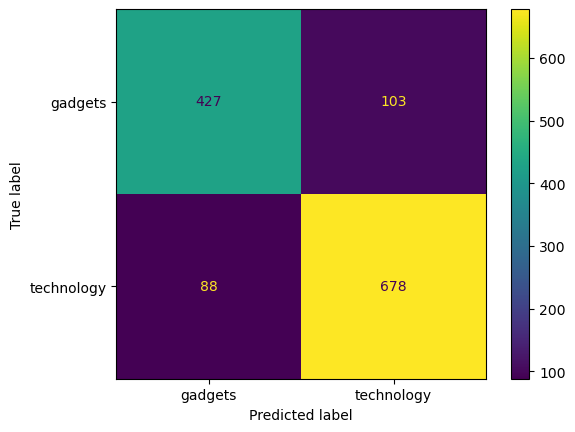

In [371]:
ConfusionMatrixDisplay.from_estimator(gs_knn,X_test,y_test);

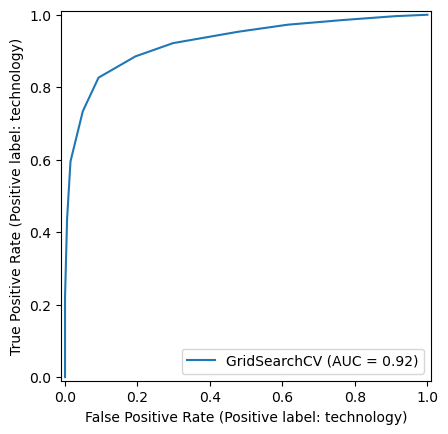

In [372]:
RocCurveDisplay.from_estimator(gs_knn,X_test,y_test);

In [373]:
### Model 3: Spacy vectors with Naive Bayes

In [378]:
pipe_nb =Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('nb',MultinomialNB())
    ]
)


grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85],           # Ignore very frequent words
    'cvec__min_df': [1, 2],                 # Ignore infrequent words
    'nb__alpha': [0.1, 0.5, 1.0]            # Smoothing parameter for Naive Bayes
}

gs_nb = GridSearchCV(pipe_nb, grid_params, n_jobs=-1, cv=5)
gs_nb.fit(X_train, y_train)

print(f' Best parameters:{gs_nb.best_params_}')
print(f' Best score:{gs_nb.best_score_}')

 Best parameters:{'cvec__max_df': 0.75, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'nb__alpha': 1.0}
 Best score:0.8689832689832692


### Model Evaluation

In [380]:
pred = gs_nb.predict(X_test)

train_accuracy = round(gs_nb.score(X_train, y_train), 2)
test_accuracy = round(gs_nb.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')

Training Accuracy of Logistic Regression with Count Vectorizer: 0.94
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.87
Training Misclassification Rate: 0.06
Testing Misclassification Rate: 0.13


In [385]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

knn_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(knn_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(recall,2)}')

Naive Bayes specificity: 0.87
Naive Bayes recall: 0.87


In [387]:
#classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     gadgets       0.82      0.87      0.84       530
  technology       0.91      0.87      0.89       766

    accuracy                           0.87      1296
   macro avg       0.86      0.87      0.87      1296
weighted avg       0.87      0.87      0.87      1296



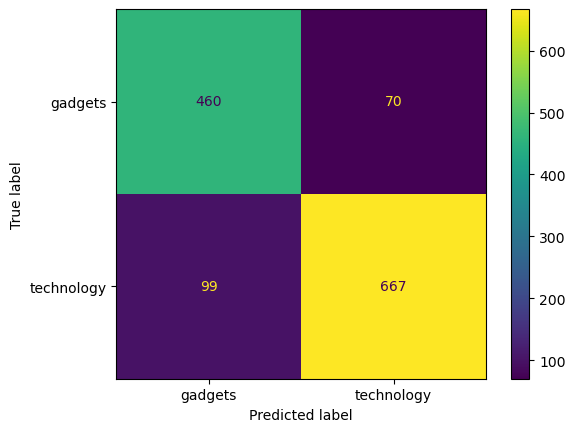

In [389]:
ConfusionMatrixDisplay.from_estimator(gs_nb,X_test,y_test);

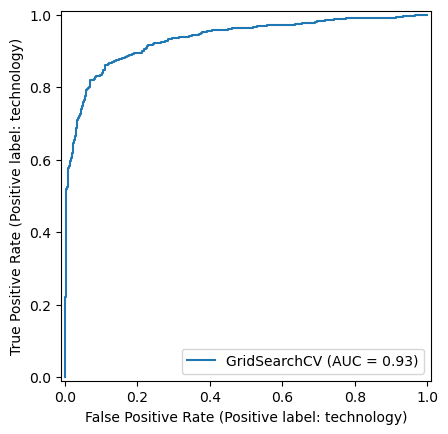

In [393]:
RocCurveDisplay.from_estimator(gs_nb,X_test,y_test);

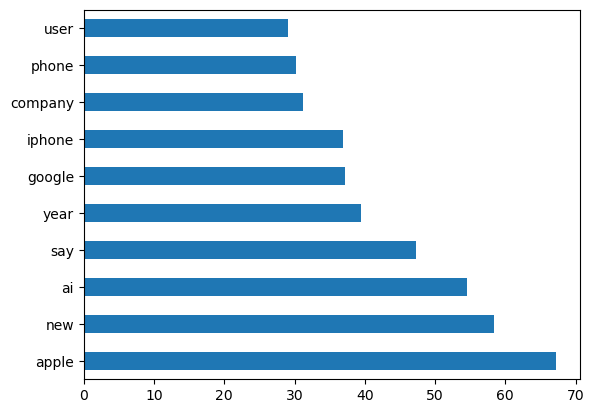